In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy import stats

In [297]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

In [212]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/'

## merge data with psychosocial data

In [213]:
df = pd.read_csv(PATH +'rus_merged_psychosocial_data.csv', index_col=0)
df = df[df.index.notnull()]
df.rename(columns={'dep.severity-1': 'dep.severity',
                  'HDRS-17.score-1': 'HDRS-17',
                   'panss-1-td': 'panss_td',
                   'panss-1-total': 'panss_total', 
                   'panss-n-1-total': 'panss_n', 
                   'panss-o-1-total': 'panss_o',
                   'panss-p-1-total': 'panss_p', 
                   'sans-1-total': 'sans',
                   'saps-ftd-1-total': 'saps_ftd', 
                   'sops-1-total': 'sops_total', 
                   'sops-c-total': 'sops_c',
                   'sops-d-total': 'sops_d', 
                   'sops-n-total': 'sops_n', 
                   'sops-p-total': 'sops_p'
                  }, inplace=True)
df['index'] = df.index
df.drop_duplicates(inplace=True, subset='index')
df.drop(columns=['index'], inplace=True)

In [215]:
len(df)

176

In [216]:
res_df = pd.read_csv(PATH + 'processed_values/ru_both.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [217]:
len(res_df)

183

In [218]:
dfi = [i.replace('-', '').replace('S', 'PD1') for i in df.index]
df.index = dfi
# res_df.index = [i.replace('S', 'PD1') for i in res_df.index]
rdfi = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]

missing_psy = set(rdfi).difference(set(dfi))
missing_psy

{'PN005', 'PN006', 'PN012', 'PN014', 'PN019', 'PN238', 'PN327'}

In [219]:
missing_psy = [i for i in res_df.index if i.split('_')[0] in missing_psy]
res_df.drop(missing_psy, inplace=True)

In [220]:
len(res_df)

176

In [221]:
missing_text = set(dfi).difference(set(rdfi))
len(missing_text)

0

In [222]:
df.drop(missing_text, inplace=True)

In [223]:
non_start_timepoint = [i for i in res_df.index if i.split('_')[-1] != '1']
res_df.drop(non_start_timepoint, inplace=True)

In [224]:
res_df.loc['PD101_1'].dropna()

TASK                               
adventure  LM         m_bert_cgcoh      0.954746
                      m_bert_gcoh       0.942201
                      m_bert_lcoh       0.873049
                      m_bert_scoh       0.865214
                      m_cgcoh           0.930773
                                         ...    
sportsman  syntactic  max_sent_len     20.000000
                      mean_sent_len     8.500000
                      min_sent_len      2.000000
                      n_sents          12.000000
                      std_sent_len      4.425306
Name: PD101_1, Length: 156, dtype: float64

In [225]:
rdfi_filtered = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]
res_df.index = rdfi_filtered

## psychosocial statistics

In [226]:
def fill_diagnosis_type(row):
    dt = row['diagnosis.type']
    if not pd.isna(dt):
        return dt
    else:
        if not pd.isna(row['td.severity']):
            return 'control_psy'
        else:
            return 'control'

In [227]:
df['diagnosis.type'] = df.apply(fill_diagnosis_type, axis=1)

In [228]:
sz = df[df['diagnosis.type'] == 'sz']
dep = df[df['diagnosis.type'] == 'dep']
control = df[df['diagnosis.group'] == 'control']
control_psy = df[df['diagnosis.type'] == 'control_psy']

In [229]:
df.columns

Index(['age', 'dep.scale', 'dep.severity', 'group.code', 'diagnosis.group',
       'diagnosis.type', 'diagnosis_code', 'diagnosis_eng', 'diagnosis_rus',
       'education.level.code', 'education.level.eng', 'education.years',
       'exacerbation', 'HDRS-17', 'longitudinal', 'panss_td', 'panss_total',
       'panss_n', 'panss_o', 'panss_p', 'rehospitalization', 'sans',
       'saps_ftd', 'sex', 'sops_total', 'sops_c', 'sops_d', 'sops_n', 'sops_p',
       'td.scales', 'td.severity'],
      dtype='object')

In [230]:
len(df)

176

In [231]:
df['diagnosis.group'].value_counts()

control    127
patient     49
Name: diagnosis.group, dtype: int64

In [232]:
df['diagnosis.type'].value_counts()

control        86
control_psy    41
sz             31
dep            18
Name: diagnosis.type, dtype: int64

In [233]:
df['dep.scale'].value_counts()

HDRS    51
QIDS    39
Name: dep.scale, dtype: int64

In [234]:
df['td.scales'].value_counts()

SCL-90-R    39
PANSS       28
SAPS        21
Name: td.scales, dtype: int64

In [235]:
print(df.groupby('diagnosis.type')[['diagnosis_code', 'diagnosis_eng']].value_counts().to_csv(sep='\t'))

diagnosis.type	diagnosis_code	diagnosis_eng	0
dep	F31	bipolar.affective.disorder	6
dep	F60.31	borderline.personality.disorder	3
dep	F31.4	bipolar.affective.disorder.severe	2
dep	F31.5	bipolar.affective.disorder.severe.psychotic	2
dep	F33	recurrent.depressive.disorder	2
dep	F32.1	depressive.episode.moderate	1
dep	F33.3	recurrent.depressive.disorder.severe.psychotic	1
dep	F60	personality.disorder	1
sz	F20	schizophrenia	20
sz	F25	schizoaffective.disorder	8
sz	F21	schizotypal.disorder	2
sz	F21.3	schizotypal.disorder.pseudoneurotic.schizophrenia	1



### select target cols

In [236]:
target_cols = ['sex', 'age', 'education.years', 
               'diagnosis.group', 'diagnosis.type',
               'dep.severity', 'td.severity']

In [237]:
# panss_cols = [col for col in df.columns if col.startswith('panss')]
panss_cols = ['panss_td', 'panss_total', 'panss_n', 'panss_p', 'panss_o']
sans_cols = [col for col in df.columns if col.startswith('sans')]
saps_cols = [col for col in df.columns if col.startswith('saps')]
sops_cols = [col for col in df.columns if col.startswith('sops')]

In [238]:
sz.count()[sz.count() > 0]

age                     31
dep.scale               31
dep.severity            31
group.code               3
diagnosis.group         31
diagnosis.type          31
diagnosis_code          31
diagnosis_eng           31
diagnosis_rus            3
education.level.code     3
education.level.eng     31
education.years         31
exacerbation             3
HDRS-17                 21
longitudinal             3
panss_td                29
panss_total             29
panss_n                 29
panss_o                 29
panss_p                 29
rehospitalization        3
sans                     3
saps_ftd                 3
sex                     31
sops_c                   1
sops_d                   1
sops_n                   1
sops_p                   1
td.scales               31
td.severity             31
dtype: int64

In [239]:
dep.count()[dep.count() > 0]

age                     18
dep.scale               18
dep.severity            18
group.code              18
diagnosis.group         18
diagnosis.type          18
diagnosis_code          18
diagnosis_eng           18
diagnosis_rus           18
education.level.code    18
education.level.eng     18
education.years         18
exacerbation            16
HDRS-17                 18
longitudinal            11
panss_td                12
panss_total             13
panss_n                 13
panss_o                 13
panss_p                 13
rehospitalization       16
sans                    17
saps_ftd                18
sex                     18
sops_c                   8
sops_d                   8
sops_n                   8
sops_p                   8
td.scales               18
td.severity             18
dtype: int64

In [240]:
def mean_std(df_data, columns, group=None):
    data = df_data.groupby(group)[columns] if group else df_data[columns]
    if group:
        df_mean, df_std = data.mean().round(2), data.std().round(2)

        df = pd.DataFrame(columns=df_mean.columns, index = df_mean.index)
        columns = df_mean.columns.tolist()
        for i, row in df_mean.iterrows():
            for c in columns:
                df.loc[i, c] = f'{df_mean.loc[i, c]} ({df_std.loc[i, c]})'
    else:
        s_mean, s_std = data.mean().round(2), data.std().round(2)
        df = pd.DataFrame(index = s_mean.index, columns=['value'])
        for i, v in s_mean.items():
            df.loc[i, 'value'] = f'{v} ({s_std.loc[i]})'
        df = df.transpose()
    return df

In [241]:
sz['sex'].value_counts()

female    25
male       6
Name: sex, dtype: int64

In [242]:
mean_std(sz, target_cols + panss_cols)

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_14713/1477061337.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_n,panss_p,panss_o
value,27.13 (7.14),13.32 (2.41),0.58 (0.85),0.84 (0.73),10.03 (3.74),69.79 (16.13),22.93 (8.59),15.9 (4.92),30.97 (8.42)


In [243]:
mean_std(sz, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_n,panss_p,panss_o
sex,,,,,,,,,
female,27.8 (7.53),13.56 (2.48),0.72 (0.89),0.8 (0.76),9.43 (3.62),69.13 (15.38),22.52 (7.79),15.3 (4.91),31.3 (9.08)
male,24.33 (4.72),12.33 (1.97),0.0 (0.0),1.0 (0.63),12.33 (3.56),72.33 (20.16),24.5 (11.93),18.17 (4.67),29.67 (5.65)


In [244]:
dep['sex'].value_counts()

female    18
Name: sex, dtype: int64

In [245]:
mean_std(dep, target_cols + panss_cols)

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_14713/1477061337.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_n,panss_p,panss_o
value,20.89 (3.71),12.67 (1.94),0.56 (0.62),0.06 (0.24),4.42 (0.9),37.92 (5.89),8.31 (1.97),8.46 (1.94),21.15 (3.58)


In [248]:
dep['panss_o'].count()

13

In [249]:
control['sex'].value_counts()

female    89
male      38
Name: sex, dtype: int64

In [250]:
mean_std(control, target_cols)

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_14713/1477061337.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity
value,40.42 (19.15),15.55 (2.54),0.0 (0.0),0.0 (0.0)


In [251]:
mean_std(control, target_cols, 'sex')

,age,education.years,dep.severity,td.severity
sex,,,,
female,38.97 (18.87),15.25 (2.33),0.0 (0.0),0.0 (0.0)
male,43.92 (19.63),16.24 (2.88),0.0 (0.0),0.0 (0.0)


In [252]:
control_psy['sex'].value_counts()

female    31
male      10
Name: sex, dtype: int64

In [253]:
mean_std(control_psy, target_cols + panss_cols)

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_14713/1477061337.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_n,panss_p,panss_o
value,27.62 (11.16),15.05 (2.07),0.0 (0.0),0.0 (0.0),4.36 (1.0),30.77 (1.54),7.23 (0.53),7.23 (0.61),16.32 (0.95)


In [254]:
mean_std(control_psy, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_n,panss_p,panss_o
sex,,,,,,,,,
female,27.19 (10.59),15.23 (1.67),0.0 (0.0),0.0 (0.0),4.4 (1.05),30.85 (1.6),7.25 (0.55),7.25 (0.64),16.35 (0.99)
male,29.11 (13.57),14.5 (3.06),0.0 (0.0),0.0 (0.0),4.0 (0.0),30.0 (0.0),7.0 (0.0),7.0 (0.0),16.0 (0.0)


In [257]:
control.groupby('sex')['panss_total'].count()

sex
female    20
male       2
Name: panss_total, dtype: int64

In [258]:
control_psy.count()[control_psy.count() > 0]

age                    40
dep.scale              41
dep.severity           41
diagnosis.group        41
diagnosis.type         41
education.level.eng    39
education.years        41
HDRS-17                22
panss_td               22
panss_total            22
panss_n                22
panss_o                22
panss_p                22
sex                    41
td.scales              39
td.severity            41
dtype: int64

In [259]:
df.dropna(axis=0, thresh=30).iloc[0]

age                                      18.0
dep.scale                                HDRS
dep.severity                              1.0
group.code                                2.0
diagnosis.group                       patient
diagnosis.type                             sz
diagnosis_code                            F21
diagnosis_eng            schizotypal.disorder
diagnosis_rus                  Шизотипическое
education.level.code                      1.0
education.level.eng     vocational.unfinished
education.years                          11.0
exacerbation                              1.0
HDRS-17                                   9.0
longitudinal                              1.0
panss_td                                  4.0
panss_total                              39.0
panss_n                                   9.0
panss_o                                  23.0
panss_p                                   7.0
rehospitalization                         0.0
sans                              

## scores

In [260]:
res_df

TASK     adventure                                                          \
                LM                                                           
      m_bert_cgcoh m_bert_gcoh m_bert_lcoh m_bert_scoh   m_cgcoh    m_gcoh   
N01            NaN         NaN         NaN         NaN       NaN       NaN   
N02            NaN         NaN         NaN         NaN       NaN       NaN   
N03            NaN         NaN         NaN         NaN       NaN       NaN   
N04            NaN         NaN         NaN         NaN       NaN       NaN   
N05            NaN         NaN         NaN         NaN       NaN       NaN   
...            ...         ...         ...         ...       ...       ...   
PD116     0.959279    0.949360    0.880519    0.885148  0.997227  0.996738   
PD121     0.963479    0.956259    0.920084    0.915321  0.903865  0.898311   
PD123     0.955438    0.942931    0.859705    0.865627  0.770681  0.737492   
PD124     0.942281    0.934072    0.832030    0.890336  0.967431  0.959681   
PD125     0.946462    0.938903    0.874884    0.847150  0.886114  0.878837   

TASK                                           ... winterday              \
                                        graph  ... syntactic               
         m_lcoh    m_scoh   m_sporb        L1  ...      PRON PROPN PUNCT   
N01         NaN       NaN       NaN       NaN  ...       NaN   NaN   NaN   
N02         NaN       NaN       NaN       NaN  ...       NaN   NaN   NaN   
N03         NaN       NaN       NaN       NaN  ...       NaN   NaN   NaN   
N04         NaN       NaN       NaN       NaN  ...       NaN   NaN   NaN   
N05         NaN       NaN       NaN       NaN  ...       NaN   NaN   NaN   
...         ...       ...       ...       ...  ...       ...   ...   ...   
PD116  0.991679  0.990629  0.978462  1.000000  ...       NaN   NaN   NaN   
PD121  0.816441  0.778602  0.965854  0.299213  ...       NaN   NaN   NaN   
PD123  0.559322  0.604235  0.939905  2.000000  ...       NaN   NaN   NaN   
PD124  0.912076  0.906460  0.898145  1.000000  ...       NaN   NaN   NaN   
PD125  0.736865  0.758299  0.985037  0.000000  ...       NaN   NaN   NaN   

TASK                                                                           
                                                                               
      SCONJ VERB max_sent_len mean_sent_len min_sent_len n_sents std_sent_len  
N01     NaN  NaN          NaN           NaN          NaN     NaN          NaN  
N02     NaN  NaN          NaN           NaN          NaN     NaN          NaN  
N03     NaN  NaN          NaN           NaN          NaN     NaN          NaN  
N04     NaN  NaN          NaN           NaN          NaN     NaN          NaN  
N05     NaN  NaN          NaN           NaN          NaN     NaN          NaN  
...     ...  ...          ...           ...          ...     ...          ...  
PD116   NaN  NaN          NaN           NaN          NaN     NaN          NaN  
PD121   NaN  NaN          NaN           NaN          NaN     NaN          NaN  
PD123   NaN  NaN          NaN           NaN          NaN     NaN          NaN  
PD124   NaN  NaN          NaN           NaN          NaN     NaN          NaN  
PD125   NaN  NaN          NaN           NaN          NaN     NaN          NaN  

[176 rows x 383 columns]

## features of raw texts

In [261]:
raw = pd.read_csv(PATH+'rus_transcript_lex_by_task_with_dots.tsv', sep='\t', index_col=0)

In [262]:
ids_to_drop = [i for i in raw.index if i.split('_')[0] not in res_df.index]

In [263]:
raw.drop(index=ids_to_drop, inplace=True)

In [264]:
raw.index = [i.split('_')[0] for i in raw.index]

In [265]:
raw.isna().sum(axis=0).sum()

1060

<AxesSubplot: >

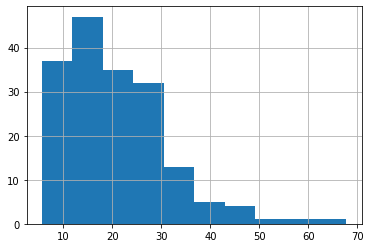

In [266]:
raw.applymap(lambda x: len(x.split('.')) if not pd.isna(x) else np.nan).mean(axis=1).hist()

## look at tasks

In [267]:
task_available = raw.applymap(lambda x: 1 if not pd.isna(x) else x)

In [268]:
len(task_available)

176

In [269]:
task_available['diagnosis.type'] = df['diagnosis.type']

In [270]:
task_available.count()

adventure          99
bench              28
chair              75
party              35
present            81
sportsman          96
table              30
trip               40
winterday          40
diagnosis.type    176
dtype: int64

In [271]:
task_available.groupby('diagnosis.type').count()

,adventure,bench,chair,party,present,sportsman,table,trip,winterday
diagnosis.type,,,,,,,,,
control,30,28,28,28,28,28,30,30,28
control_psy,25,0,16,7,19,26,0,9,12
dep,14,0,14,0,13,14,0,0,0
sz,30,0,17,0,21,28,0,1,0


In [272]:
task_available.groupby('diagnosis.type').count()[task_available.groupby('diagnosis.type').count() > 0].dropna(axis=1)

,adventure,chair,present,sportsman
diagnosis.type,,,,
control,30,28,28,28
control_psy,25,16,19,26
dep,14,14,13,14
sz,30,17,21,28


In [273]:
def drop_person(row):
    for task in ('adventure', 'chair','present','sportsman'):
        if not pd.isna(row[task]):
            return False
    return True

In [274]:
ids_with_at_least_one_task = task_available[~task_available.apply(drop_person, axis=1)].index

In [275]:
df = df.loc[ids_with_at_least_one_task]

In [276]:
res_df = res_df.loc[ids_with_at_least_one_task, ['adventure', 'chair', 'present', 'sportsman']]

In [277]:
def task_data(df, task, keep_target=True, fill_synt=True):
    subset = df[task].dropna(axis=0, how='all')
    if fill_synt:
        subset['syntactic'] = subset['syntactic'].fillna(0.0)
    if keep_target:
        subset = pd.concat([subset, df['target'].loc[subset.index]], axis=1)
    return subset

In [278]:
def aplly_to_all_tasks(df, f, tasks=('adventure', 'chair','present','sportsman'), to_df=True, *args, **kwargs):
    res = {}
    for task in tasks:
        data = task_data(df, task)
        res[task] = f(data, *args, **kwargs)
    return pd.DataFrame(res)

### merge psychoscial data to scores

In [279]:
merge_df = res_df.copy()
for col in target_cols + panss_cols:
    merge_df[('target', 'target', col)] = df[col]

In [280]:
merge_df['chair'].dropna(axis=0, how='all')

LM                                                          \
      m_bert_cgcoh m_bert_gcoh m_bert_lcoh m_bert_scoh   m_cgcoh    m_gcoh   
N02       0.907379    0.894173    0.892853    0.778331  0.859000  0.838311   
N07       0.956381    0.955130    0.935352    0.933666  0.777727  0.734761   
N09       0.970384    0.964711    0.942394    0.925433  0.999755  0.999696   
N13       0.977305    0.966893    0.950994    0.923762  0.830714  0.816151   
N17       0.956932    0.940715    0.909069    0.925338  0.776746  0.699820   
...            ...         ...         ...         ...       ...       ...   
PN020     0.973917    0.970394    0.937589    0.950313  0.999079  0.998913   
PN021     0.960883    0.952544    0.929937    0.929935  0.917792  0.907508   
PD107     0.957607    0.943778    0.900488    0.894012  0.876956  0.864955   
PD115     0.954370    0.949186    0.909227    0.859706  0.975395  0.969217   
PD116     0.956023    0.932437    0.888154    0.903945  0.999995  0.999994   

                                        graph  ... syntactic            \
         m_lcoh    m_scoh   m_sporb        L1  ...     PROPN     PUNCT   
N02    0.739677  0.719709  0.998406  1.544118  ...       NaN  0.083333   
N07    0.602678  0.636684  0.985360  1.000000  ...  0.015152  0.143939   
N09    0.999152  0.999085  0.999479  0.000000  ...  0.018868  0.113208   
N13    0.731150  0.612277  0.996654  0.000000  ...       NaN  0.109375   
N17    0.439527  0.588899  0.884954  0.000000  ...  0.013889  0.194444   
...         ...       ...       ...       ...  ...       ...       ...   
PN020  0.997459  0.997426  0.982177  1.444444  ...       NaN  0.088398   
PN021  0.819539  0.818349  0.942224  0.421277  ...       NaN  0.113433   
PD107  0.735897  0.702785  0.815587  0.000000  ...  0.005102  0.147959   
PD115  0.961751  0.959043  0.900109  0.000000  ...       NaN  0.130841   
PD116  0.999987  0.999986  0.963407  2.000000  ...       NaN  0.115942   

                                                                         \
          SCONJ SPACE      VERB max_sent_len mean_sent_len min_sent_len   
N02    0.005952   NaN  0.119048         20.0     11.200000          3.0   
N07    0.022727   NaN  0.113636         15.0      6.600000          3.0   
N09    0.018868   NaN  0.150943         18.0      7.571429          4.0   
N13    0.015625   NaN  0.132812         16.0      8.533333          3.0   
N17         NaN   NaN  0.111111         17.0     10.285714          2.0   
...         ...   ...       ...          ...           ...          ...   
PN020  0.016575   NaN  0.099448         23.0     10.647059          5.0   
PN021  0.020896   NaN  0.143284         21.0      8.589744          1.0   
PD107  0.025510   NaN  0.158163         16.0      6.533333          1.0   
PD115  0.018692   NaN  0.084112         13.0      7.133333          2.0   
PD116       NaN   NaN  0.130435         21.0      7.666667          1.0   

                            
      n_sents std_sent_len  
N02      15.0     5.256108  
N07      20.0     3.455431  
N09       7.0     4.531072  
N13      15.0     3.947432  
N17       7.0     4.772369  
...       ...          ...  
PN020    17.0     4.418426  
PN021    39.0     4.136876  
PD107    30.0     3.913509  
PD115    15.0     3.422799  
PD116     9.0     5.617433  

[75 rows x 42 columns]

In [281]:
def corr(df, target):
    return df[~pd.isnull(df[target])].corr()[target]

In [282]:
def corr_thresh(df, target, thresh=0.3, drop_target=True):
    corr_tgt = corr(df, target)
    corr_tgt.drop('target', inplace=True)
    return corr_tgt[abs(corr_tgt) >= thresh]

In [292]:
import copy
cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_under("white")

def color_nan_white(val):
    """Color the nan text white"""
    if np.isnan(val):
        return 'color: white'

def color_nan_white_background(val):
    """Color the nan cell background white"""
    if np.isnan(val):
        return 'background-color: white'

In [311]:
def style(df, vmin=None, vmax=None, cmap='Blues'):
    return(df.style
            .background_gradient(vmin=vmin, vmax=vmax, cmap=cmap)
            .applymap(lambda x: color_nan_white(x))
            .applymap(lambda x: color_nan_white_background(x))
        )

In [312]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'age')))

In [313]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'education.years')))

In [314]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_p')))

In [315]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_n')))